# Классификация комментариев


Обучение модели классифицировать комментарии на позитивные и негативные. 
Данные представленны набором текстов комментраиев с разметкой о токсичности правок.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Подготовка

In [1]:
import numpy as np
import pandas as pd
import torch
import transformers
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re

from tqdm import tqdm
from tqdm import notebook

from sklearn.utils import shuffle
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.model_selection import RandomizedSearchCV

from sklearn.feature_extraction.text import TfidfVectorizer

from nltk.corpus import stopwords

from nltk.stem import WordNetLemmatizer

from lightgbm import LGBMClassifier

from catboost import CatBoostClassifier

In [2]:
try:
    df_comments = pd.read_csv('/Users/admin/Downloads/toxic_comments.csv')
    
except:
    df_comments = pd.read_csv('https://code.s3.yandex.net//datasets/toxic_comments.csv')

In [3]:
df_comments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB


1. Данные представлены 159292 значениями и 3 признаками

In [4]:
df_comments.head()

,Unnamed: 0,text,toxic
0,0,Explanation\nWhy the edits made under my usern...,0
1,1,D'aww! He matches this background colour I'm s...,0
2,2,"Hey man, I'm really not trying to edit war. It...",0
3,3,"""\nMore\nI can't make any real suggestions on ...",0
4,4,"You, sir, are my hero. Any chance you remember...",0


In [5]:
df_comments = df_comments.drop('Unnamed: 0', axis=1)

1. Данные сожержат текст комментария и разметку о токсичности, третий признак удалим

In [6]:
df_comments['text'].duplicated().sum()

0

In [7]:
df_comments['text'].isna().sum()

0

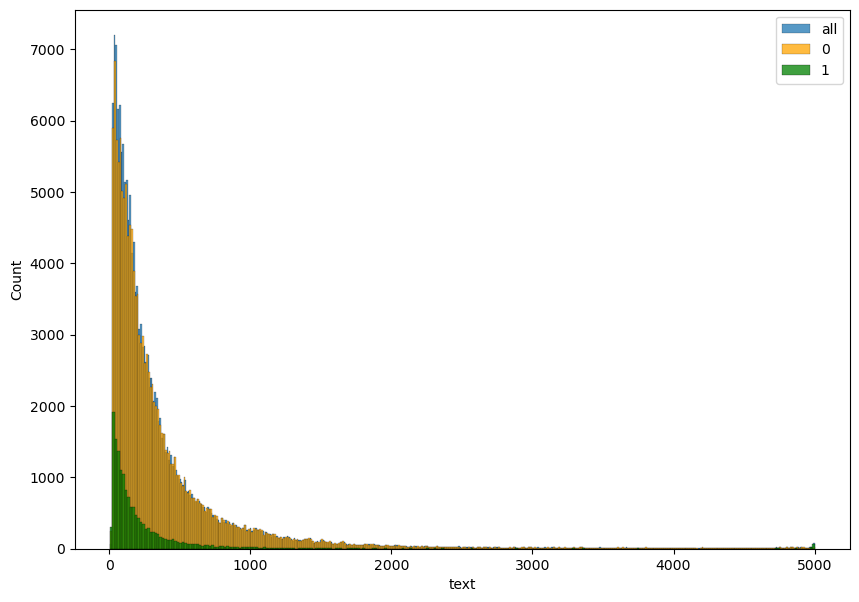

In [8]:
plt.figure(figsize=(10,7))
sns.histplot(df_comments['text'].str.len())
sns.histplot(df_comments['text'][df_comments['toxic']==0].str.len(), color='orange')
sns.histplot(df_comments['text'][df_comments['toxic']!=0].str.len(), color='green')
plt.legend(['all', '0', '1'])

1. В данных нет повтовро и пропусков
1. По количеству символов данные распределены до 5000 знаков, основная часть до 1000 знаков

In [9]:
df = df_comments.copy()

In [10]:
df_sample = df.sample(n=512, random_state=42).reset_index(drop=True)

1. Создадим выборку с 2048 значениями

In [11]:
df_sample['toxic'].value_counts()

0    453
1     59
Name: toxic, dtype: int64

1. Значения в выборке несбалансированы, больше значений 0 класса

In [ ]:
tokenizer = transformers.BertTokenizer.from_pretrained("bert-base-uncased")

tokenized = df['text'].apply(
    lambda x: tokenizer.encode(x, add_special_tokens=True, max_length=512, truncation=True))

max_len = 0
for i in tokenized.values:
    if len(i) > max_len:
        max_len = len(i)
padded = np.array([i + [0]*(max_len - len(i)) for i in tokenized.values])

attention_mask = np.where(padded != 0, 1, 0)

In [ ]:
max_len

1. Выполним токенизацию текстов
1. Приведем все токены к одной длине, длина определена выбранной максимальной длиной строки в выборке
1. Создадим маску для токенов

In [ ]:
config = transformers.BertConfig.from_pretrained("bert-base-uncased")
model = transformers.BertModel.from_pretrained("bert-base-uncased")

1. Инициализируем предобученную модель BERT обученную на разговорном английском, и конфигурацию параметров модели из json-файла
1. Адрес расположения взятой модели https://huggingface.co/DeepPavlov/bert-base-cased-conversational/tree/main

In [ ]:
batch_size = 512
embeddings = []
for i in tqdm(range(padded.shape[0] // batch_size)):
        batch = torch.LongTensor(padded[batch_size*i:batch_size*(i+1)]) 
        attention_mask_batch = torch.LongTensor(attention_mask[batch_size*i:batch_size*(i+1)])
        
        with torch.no_grad():
            batch_embeddings = model(batch, attention_mask=attention_mask_batch)
        
        embeddings.append(batch_embeddings[0][:,0,:].numpy())

1. Сформируем вектора с помощью модели BERT и объединим их в список

**TF-IDF**

In [12]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /Users/admin/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [13]:
stop_words = set(stopwords.words('english'))

In [14]:
count_tf_idf = TfidfVectorizer(stop_words=list(stop_words))

1. Для оценки величины TF-IDF создадим счётчик, указав в нём стоп-слова

## Обучение

**BERT**

In [ ]:
features = np.concatenate(embeddings)
target = df_sample['toxic']

1. Создадим обучающием признаки из эмбендингов и целевой признак из столбца с разметкой токсичности

In [ ]:
features_train, features_test, target_train, target_test = train_test_split(features, target, 
                                                                            test_size=0.2, random_state=42)

1. Разделим выборки на обучающую и тествоую

In [18]:
model = LogisticRegression(max_iter=1000, solver='liblinear', class_weight='balanced')

In [ ]:
%%time

parameters = {
    'penalty':['l1', 'l2', 'elasticnet'],
    'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
}

grid = RandomizedSearchCV(model, parameters, scoring='f1')
grid.fit(features_train, target_train)

model.fit(features_train, target_train)

logreg_tuned = grid.best_estimator_

logreg_f1_tuned = grid.best_params_
logreg_f1_regular = f1_score(target_train, model.predict(features_train))

In [ ]:
print('f1 на модели LogisticRegression = %f' % (grid.best_score_))

1. Для модели LogisticRegression установим число итераций 1000 для сходимости, solver='liblinear', class_weight='balanced'

In [21]:
model = LGBMClassifier(objective='binary', is_unbalance=True, random_state=42)

In [ ]:
%%time

parameters = {
    'num_leaves': [7, 14, 21],
    'learning_rate': [0.1, 0.03],
    'max_depth': [-1, 3, 5],
    'n_estimators': [100, 200, 500],
}

grid = RandomizedSearchCV(model, parameters, scoring='f1')
grid.fit(features_train, target_train)

model.fit(features_train, target_train)

lgbm_tuned = grid.best_estimator_

lgbm_f1_tuned = grid.best_params_
lgbm_f1_regular = f1_score(target_train, model.predict(features_train))

In [ ]:
print('f1 на модели LGBMClassifier = %f' % (grid.best_score_))

1. Для модели LGBMClassifier укажем что о классы не сбалансированы и установим objective='binary'
1. Проведем RandomizedSearchCV для гиперпараметров

Для обучения и предсказания на тестовой выборке выберем модель LogisticRegression, поскольку показатель для этой модели выше f1

In [ ]:
model = logreg_tuned
predicted_test = model.predict(features_test)
f1_test = f1_score(target_test, predicted_test)

In [ ]:
print('f1 на тестовой выборке = %f' % (f1_test))

**TF-IDF**

In [26]:
def lemmatize(text):
    m = WordNetLemmatizer()
    lemm_list = m.lemmatize(text)
    lemm_text = "".join(lemm_list)
        
    return lemm_text

def clear_text(text):
    return " ".join((re.sub(r'[^a-zA-Z]', ' ', text)).split())

In [27]:
df['clearlemm'] = df['text'].apply(lambda x: lemmatize(clear_text(x)))

In [28]:
df.head()

,text,toxic,clearlemm
0,Explanation\nWhy the edits made under my usern...,0,Explanation Why the edits made under my userna...
1,D'aww! He matches this background colour I'm s...,0,D aww He matches this background colour I m se...
2,"Hey man, I'm really not trying to edit war. It...",0,Hey man I m really not trying to edit war It s...
3,"""\nMore\nI can't make any real suggestions on ...",0,More I can t make any real suggestions on impr...
4,"You, sir, are my hero. Any chance you remember...",0,You sir are my hero Any chance you remember wh...


In [29]:
features = df['clearlemm']
target = df['toxic']
features_train, features_test, target_train, target_test = train_test_split(features, target, 
                                                                            test_size=0.2, random_state=42)
corpus = features_train.values
corpus_test = features_test.values
tf_idf_train = count_tf_idf.fit_transform(corpus)
tf_idf_test = count_tf_idf.transform(corpus_test)

print(tf_idf_train.shape, tf_idf_test.shape)

(127433, 147295) (31859, 147295)


1. Выполним очитску текста и лемматизацию
1. Подсчитаем величину TF-IDF для текстов

In [30]:
model = LogisticRegression(max_iter=1000, solver='liblinear', class_weight='balanced')
f1_mean = np.mean(cross_val_score(model, tf_idf_train, target_train, scoring='f1'))
print('f1 на кросс-валидации = %f' % (f1_mean))

f1 на кросс-валидации = 0.752584


1. На модели LogisticRegression значение f1 удовлетворяет условию

In [31]:
model = LGBMClassifier(objective='binary', is_unbalance=True, random_state=42)
f1_mean = np.mean(cross_val_score(model, tf_idf_train, target_train, scoring='f1'))
print('f1 на кросс-валидации = %f' % (f1_mean))

f1 на кросс-валидации = 0.732332


1. На модели LGBMClassifier значение f1 ниже требуемого по условию
1. Для предсказания на тестовой выборке используем модель LogisticRegression

In [32]:
model = LogisticRegression(max_iter=1000, solver='liblinear', class_weight='balanced')
model.fit(tf_idf_train, target_train)
predicted_test = model.predict(tf_idf_test)
f1_test = f1_score(target_test, predicted_test)

In [33]:
print('f1 на тестовой выборке = %f' % (f1_test))

f1 на тестовой выборке = 0.752431


1. Результаты на тестовой выборке удовлетворяют условию задачи

## Выводы

1. В данной работе была решена задача распознавания токсичных комментариев


1. Для анализа и обучения модели были предоставленны данные состоящие из 159292 значений, содержащих в седе комментарий и разметку о токсичности


1. Поскольку выполнение задачи производилось с помощью BERT, то для ускорения работы и совместимости с нейронкой из исходного датасета были взяты 2048 значений с длиной текста до 512 символов


1. Модель BERT взята из открытого репозитория DeepPavlov


1. Для создания признаков для обучения моделей текст был преобразован следующим образом:
    1. Выполнена токенизация текстов
    1. Примедены все токены к одной длине, длина определена выбранной максимальной длиной строки в выборке
    1. Создадана маска для токенов
    1. С применением BERT тесты преобразованы в тензоры
    
    
1. Для выбора модели провели сравнение двух моделей: LogisticRegression и LGBMClassifier
    1. Модель LogisticRegression:
        1. было выбрано число итераций 1000, поскольку при меньшем модель не сходилась
        1. f1 на кроссвалидации составила 0.658
    1. Модель  LogisticRegression:
        1. проведен RandomizedSearchCV для гиперпараметров
        1. f1 на кроссвалидации составила 0.613
    1. По итогу сравнения была выбрана модель LogisticRegression
    
1. Поскольку на модели BERT достичь требуемого результат не получилось, был вычислен TF-IDF для корпуса текстов
1. После сравнения результатов на валидациии для решения задачи была выбрана модель LogisticRegression
1. Оценка на тестовой выборке составила f1 = 0.75


По итогу метрика качества была достигнута с помощью вычислен TF-IDF для корпуса текстов и модели LogisticRegression